In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import random
import os, cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**finding**

number of frames is done by 0.25 X real\_frames(75), 0.05 X fake\_frames(15)
- train(random single frame)<br>
selected = random.randint(0, n_frames - 1)

# MyDataset

In [21]:
df = pd.read_csv('/Users/dph/downloads/data-deepfake98493/metadata.csv')
def add_prefix(p):
    return os.path.join('/Users/dph/downloads/data-deepfake98493/', p)
def change_label(l):
    return ['REAL', 'FAKE'].index(l)
df['path'] = list(map(add_prefix, df['name_path'].values))
df['label'] = list(map(change_label, df['label'].values))

In [22]:
# the add_path is correct
print(df.loc[0, 'name_path'])
print(df.loc[0, 'path'])

dfdc_train_part_43/vhphtddasg.jpg
/Users/dph/downloads/data-deepfake98493/dfdc_train_part_43/vhphtddasg.jpg


In [27]:
# balance
real_df = df[df.label==0]
fake_df = df[df.label==1].sample(len(real_df))
print(len(real_df), len(fake_df))

# shuffle
train_df = shuffle(pd.concat([real_df, fake_df]))
test_df = df[~df.index.isin(train_df.index)]


# split
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(len(train_df), len(val_df), len(test_df))

16074 16074
25718 6430 66345


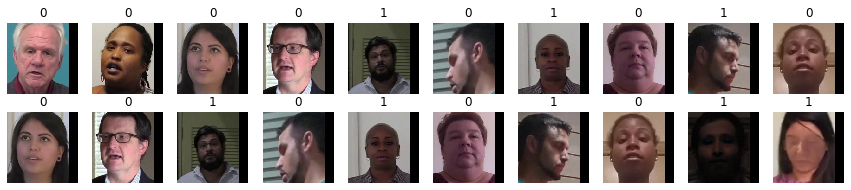

In [35]:
# show train sample images

fig, ax = plt.subplots(2, 10, figsize=(15, 3))
for i in range(2):
    for j in range(10):
        img = cv2.cvtColor(cv2.imread(train_df.loc[i*2+j, 'path']), cv2.COLOR_BGR2RGB)
        ax[i][j].imshow(img)
        ax[i][j].set_title(train_df.loc[i*2+j, 'label'])
        ax[i][j].axis('off')

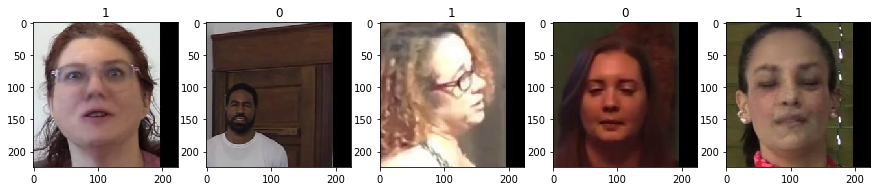

In [37]:
# show val sample images
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for j in range(5):
    img = cv2.cvtColor(cv2.imread(val_df.loc[j, 'path']), cv2.COLOR_BGR2RGB)
    ax[j].imshow(img)
    ax[j].set_title(val_df.loc[j, 'label'])

In [44]:
from albumentations import Normalize, HorizontalFlip, Compose
train_tf = Compose([HorizontalFlip(p=0.5), 
                   Normalize()])
val_tf = Compose([Normalize()])

In [45]:
class MyDataset(Dataset):
    def __init__(self, df, split):
        super().__init__()
        self.df = df
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        img = cv2.cvtColor(cv2.imread(self.df.loc[idx, 'path']), cv2.COLOR_BGR2RGB)
        if self.split == 'train':
            img = train_tf(**{'image':img})['image']
        elif self.split == 'val':
            img = val_tf(**{'image': img})['image']
        img = torch.tensor(img).permute(2, 0, 1).float()

        
#         label = torch.tensor(['REAL', 'FAKE'].index(self.df.loc[idx, 'label'])).float()
        label = torch.tensor(self.df.loc[idx, 'label']).float()
    
        return {'image':img,'label': label}
        

In [47]:
train_data = MyDataset(train_df, 'train')
print(train_data[0]['image'].shape, train_data[0]['label'])
train_dl = DataLoader(train_data, batch_size=64, num_workers=0, pin_memory=True)
print(len(train_dl))

val_data = MyDataset(val_df, 'val')
print(val_data[0]['image'].shape, val_data[0]['label'])
val_dl = DataLoader(val_data, batch_size=64, num_workers=0, pin_memory=True)
print(len(val_dl))

torch.Size([3, 224, 224]) tensor(0.)
402
torch.Size([3, 224, 224]) tensor(1.)
101


# 4th Code

In [48]:
# Bilinear Attention Pooling
class BAP(nn.Module):
    def __init__(self, pool='GAP'):
        super(BAP, self).__init__()
        assert pool in ['GAP', 'GMP']
        if pool == 'GAP':
            self.pool = None
        else:
            self.pool = nn.AdaptiveMaxPool2d(1)

        self.dropout = nn.Dropout2d()

    def forward(self, features, attentions, dropout=False):
        B, C, H, W = features.size()
        _, M, AH, AW = attentions.size()

        # match size
        if AH != H or AW != W:
            attentions = F.upsample_bilinear(attentions, size=(H, W))

        # feature_matrix: (B, M, C) -> (B, M * C)
        if self.pool is None:
            feature_matrix = (torch.einsum('imjk,injk->imn', (attentions, features)) / float(H * W))
            if dropout:
                feature_matrixd = self.dropout(feature_matrix).view(B, -1)
            feature_matrix = feature_matrix.view(B, -1)
        else:
            feature_matrix = []
            for i in range(M):
                AiF = self.pool(features * attentions[:, i:i + 1, ...]).view(B, -1)
                feature_matrix.append(AiF)
            feature_matrix = torch.cat(feature_matrix, dim=1)

        # sign-sqrt
        feature_matrix = torch.sign(feature_matrix) * torch.sqrt(torch.abs(feature_matrix) + EPSILON)

        # l2 normalization along dimension M and C
        feature_matrix = F.normalize(feature_matrix, dim=-1)
        if dropout:
            feature_matrixd = torch.sign(feature_matrixd) * torch.sqrt(torch.abs(feature_matrixd) + EPSILON)
            feature_matrixd = F.normalize(feature_matrixd, dim=-1)
            return feature_matrix, feature_matrixd
        return feature_matrix